In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()

In [2]:
DP_DIR = 'E:\\DLDATA\\all'
INPUT_DIR = 'E:\\DLDATA\\all\\'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [3]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)
def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [4]:
EPOCHS = 16
batchsize = 128
size = 32
STEPS = 10000

In [5]:
model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 33, 33, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)        128       
__________

In [6]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [7]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 32, 32, 1) (34000, 340)
Validation array memory 0.13 GB


In [8]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

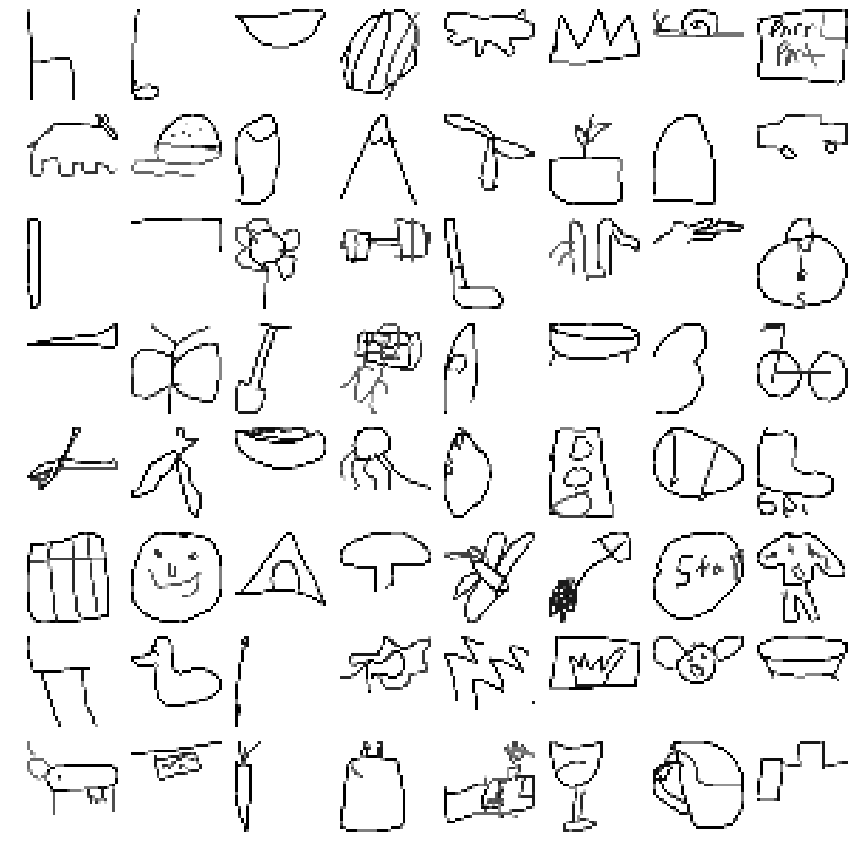

In [9]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs1.png', dpi=300)
plt.show();

In [10]:
x, y = next(train_datagen)

In [11]:
callbacks = [
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    ModelCheckpoint('modelsmallparameter.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=70, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/70
10000/10000 [==============================] - 421s 42ms/step - loss: 2.9122 - categorical_crossentropy: 2.9122 - categorical_accuracy: 0.3375 - top_3_accuracy: 0.5326 - val_loss: 2.2483 - val_categorical_crossentropy: 2.2483 - val_categorical_accuracy: 0.4565 - val_top_3_accuracy: 0.6724
Epoch 2/70
10000/10000 [==============================] - 404s 40ms/step - loss: 1.9374 - categorical_crossentropy: 1.9374 - categorical_accuracy: 0.5261 - top_3_accuracy: 0.7338 - val_loss: 1.7911 - val_categorical_crossentropy: 1.7911 - val_categorical_accuracy: 0.5571 - val_top_3_accuracy: 0.7610
Epoch 3/70
10000/10000 [==============================] - 394s 39ms/step - loss: 1.7100 - categorical_crossentropy: 1.7100 - categorical_accuracy: 0.5779 - top_3_accuracy: 0.7756 - val_loss: 1.7313 - val_categorical_crossentropy: 1.7313 - val_categorical_accuracy: 0.5756 - val_top_3_accuracy: 0.7708
Epoch 4/70
10000/10000 [==============================] - 405s 41ms/step - loss: 1.6026 - categor

10000/10000 [==============================] - 404s 40ms/step - loss: 1.1782 - categorical_crossentropy: 1.1782 - categorical_accuracy: 0.7030 - top_3_accuracy: 0.8647 - val_loss: 1.1457 - val_categorical_crossentropy: 1.1457 - val_categorical_accuracy: 0.7156 - val_top_3_accuracy: 0.8701
Epoch 28/70
10000/10000 [==============================] - 406s 41ms/step - loss: 1.1716 - categorical_crossentropy: 1.1716 - categorical_accuracy: 0.7045 - top_3_accuracy: 0.8657 - val_loss: 1.1712 - val_categorical_crossentropy: 1.1712 - val_categorical_accuracy: 0.7081 - val_top_3_accuracy: 0.8654
Epoch 29/70
10000/10000 [==============================] - 404s 40ms/step - loss: 1.1794 - categorical_crossentropy: 1.1794 - categorical_accuracy: 0.7030 - top_3_accuracy: 0.8646 - val_loss: 1.1779 - val_categorical_crossentropy: 1.1779 - val_categorical_accuracy: 0.7059 - val_top_3_accuracy: 0.8666
Epoch 30/70
 9998/10000 [============================>.] - ETA: 0s - loss: 1.1712 - categorical_crossentro

10000/10000 [==============================] - 404s 40ms/step - loss: 1.0761 - categorical_crossentropy: 1.0761 - categorical_accuracy: 0.7275 - top_3_accuracy: 0.8800 - val_loss: 1.0948 - val_categorical_crossentropy: 1.0948 - val_categorical_accuracy: 0.7263 - val_top_3_accuracy: 0.8770
Epoch 51/70
10000/10000 [==============================] - 405s 41ms/step - loss: 1.0738 - categorical_crossentropy: 1.0738 - categorical_accuracy: 0.7283 - top_3_accuracy: 0.8803 - val_loss: 1.0658 - val_categorical_crossentropy: 1.0658 - val_categorical_accuracy: 0.7327 - val_top_3_accuracy: 0.8814
Epoch 52/70
 9998/10000 [============================>.] - ETA: 0s - loss: 1.0767 - categorical_crossentropy: 1.0767 - categorical_accuracy: 0.7279 - top_3_accuracy: 0.8798
Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.000266967763309367.
10000/10000 [==============================] - 404s 40ms/step - loss: 1.0767 - categorical_crossentropy: 1.0767 - categorical_accuracy: 0.7279 - top_3_accur

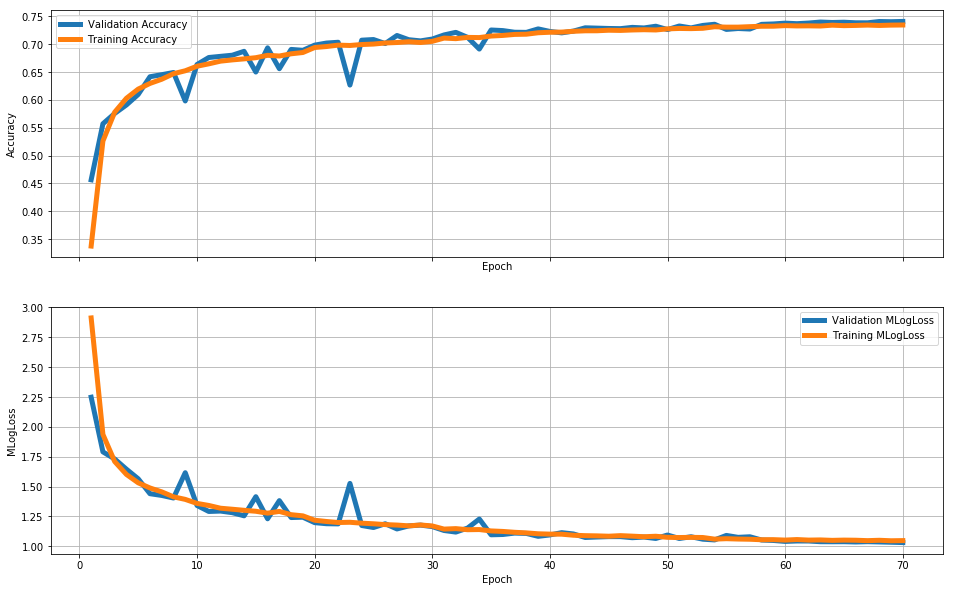

In [12]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('histsmallparameter.png', dpi=300)
plt.show();

In [13]:
hist_df.to_csv("history_of_grayscale_smallparameter.csv")

In [14]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

34000/34000 [==============================] - 4s 111us/step
Map3: 0.805


In [15]:
model.save_weights("smallparameter.h5")

In [16]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


(112199, 3) (112199, 32, 32, 1)
Test array memory 0.43 GB


In [17]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

112199/112199 [==============================] - 10s 91us/step


,a,b,c
0,234,281,238
1,144,36,280
2,305,62,110
3,187,303,241
4,56,113,232


(112199, 3)

,a,b,c
0,radio,stereo,remote_control
1,hockey_puck,bottlecap,steak
2,The_Great_Wall_of_China,castle,fence
3,mountain,tent,roller_coaster
4,campfire,fireplace,rabbit


(112199, 3)

In [18]:


test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('submission_{}smallparameter.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape



,key_id,word
0,9000003627287624,radio stereo remote_control
1,9000010688666847,hockey_puck bottlecap steak
2,9000023642890129,The_Great_Wall_of_China castle fence
3,9000038588854897,mountain tent roller_coaster
4,9000052667981386,campfire fireplace rabbit


(112199, 2)

In [19]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2019-01-05 19:56:16.423477.
Total time 28318s
